# Objective

The aim of this notebook is trying different methods to enable my computer to recognize different digits.

We will be working with the MNIST dataset. 

$\textbf{Part 1 : statistical approach}$

First I will only be using the knowledges that I have learned in statistics.
I will try to approximate the probability of each pixel to be Black or White by using the Likelyhood function.

$\textbf{Part 2 : an approach by neural networks}$

In this part I will build a simple neural networks from scratch

$\textbf{Part 3: an approach by convolutional neural networks}$

Finally, we will see that the best method to recognize digits is using convolutional neural networks

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from PIL import Image
from tensorflow.keras.utils import to_categorical


In [6]:
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

# we binarize the images
threshold = 127
x_train_binary = tf.cast(x_train > threshold, tf.float32)
x_test_binary = tf.cast(x_test > threshold, tf.float32)

# Part 1

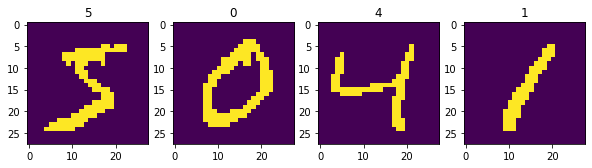

In [4]:
#we visualize the dataset

fig, ax = plt.subplots(ncols=4,figsize=(10,10))
for i in range(4):
    ax[i].imshow(x_train_binary[i])
    ax[i].title.set_text(y_train[i])

In [5]:
x_train_binary.shape

TensorShape([60000, 28, 28])

# Mathematical process behind the model

$\textbf{First let's define our objects.}$

Let $N$ be the number of images in our dataset and $K$ the number of pixels (28x28 in our case).
We suppose that every pixel is a random variable and for every image, the same pixels has the same distribution and are independant.

We note $X^{(n)}_k$ the k-th pixel of the n-th image.

As supposed before, $ \forall n \in\{0,1,...,N\}$, $X^{(n)}_k$  are iid.

We are going to explain the process for a single pixel but it is the same for every pixel.


$\textbf{Let's search the probabilty of a pixel to be Black, knowing that it is a certain class}$

Let $k\in\{0,1,...,K\}$

We suppose that $ \forall n \in\{0,1,...,N\}$, 
$X^{(n)}_k \sim \mathcal{B}(\theta)$

The aim is, knowing that the image belong to a certain class, trying to find what is the $\theta$ that maximize the probability of every image to belong to the class.

$$\max_{\theta}\mathcal{P}(X^{(1)}_k = x_1 , ... , X^{(n)}_k = x_n) \, \,\, with \,\, x_i\in\{0,1\}$$
$$ = \max_{\theta}\prod_{n=1}^N \mathcal{P}(X^{(n)}_k) \, , \, by \,\, independance $$
$$ = \max_{\theta}\, \mathcal{L}(\theta)= {\theta}^{\sum_{n=1}^{N}}(1-\theta)^{N-\sum_{n=1}^{N}} \, \, because \, \forall n \in\{0,1,...,N\}\, , \,X^{(n)}_k \sim \mathcal{B}(\theta)$$

We use the first order condition,
$$ \frac{\partial\mathcal{L}}{\partial\theta}=0 \Rightarrow \theta = \frac{\sum_{n=1}^N  X^{(n)}_k}{N} $$

In the model below we use the formula we just found for $\theta$ and we use it for every pixel and every class.

In [10]:
# We build the matrices of probabilities of every pixel for every number from 0 to 9

def build_model(x_train,y_train):
    prob_matrices = np.zeros((10, 28, 28))

    for j in range(10):
        mask = (y_train == j)  # we take the elements that correspond to class j
        class_samples = x_train[mask]

        # we compute the sum for every position (every pixel) (row,col)
        sums = np.sum(class_samples, axis=0)

        # Calculate probabilities by dividing by the number of samples in class j
        prob_matrices[j] = sums / len(class_samples)

    return prob_matrices


In [7]:
#We train the model

prob_matrices=build_model(x_train_binary,y_train)


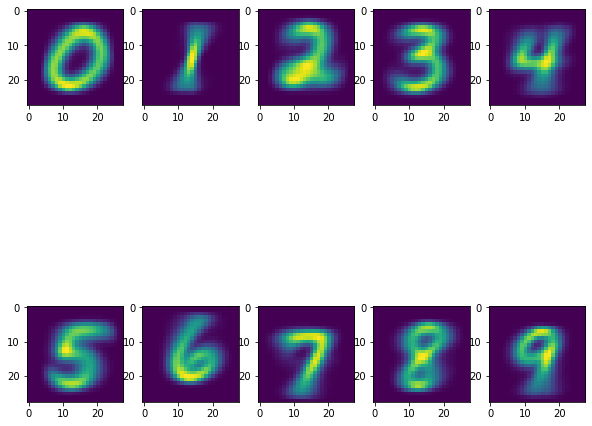

In [8]:
#we visualize the results
fig, ax =plt.subplots(ncols=5,nrows=2,figsize=(10,10))

s=0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(prob_matrices[s])
        s+=1
    
    

In [9]:
def predict(data,prob_matrices):
    
    prediction_vector=np.zeros(10)
    
    rows=len(data)
    cols=len(data[0])
    
    for row in range(rows):
        for col in range(cols):
            if data[row][col]==1:
                for classes in range(10):
                    #if the pixel is black there we sum the probability of having a black pixel knowing that
                    #it is class X
                    prediction_vector[classes]+=prob_matrices[classes][row][col]
                    
            #We dont treat the case where the pixel is white because there are too many places where the pixels are
            #white and it does not give more information (for examples the corners)
    return np.argmax(prediction_vector)

# Accuracy

We obtains an accuracy of 0.64.

Knowing that neural networks have a +98% accuracy I think we can do better :(

In [ ]:
s=0
for i in range(100):
    if predict(x_test_binary[i],prob_matrices)==y_test[i]:
        s+=1
print("the accuracy is : ", s/100)

# Part 2 : an approach by neural networks

We will try to build a simple neural networks from scratch that will classify the images.

The neural network will have 2 hidden layers, take in input a 784 dim vector (28x28) and for output : a 10dim vector

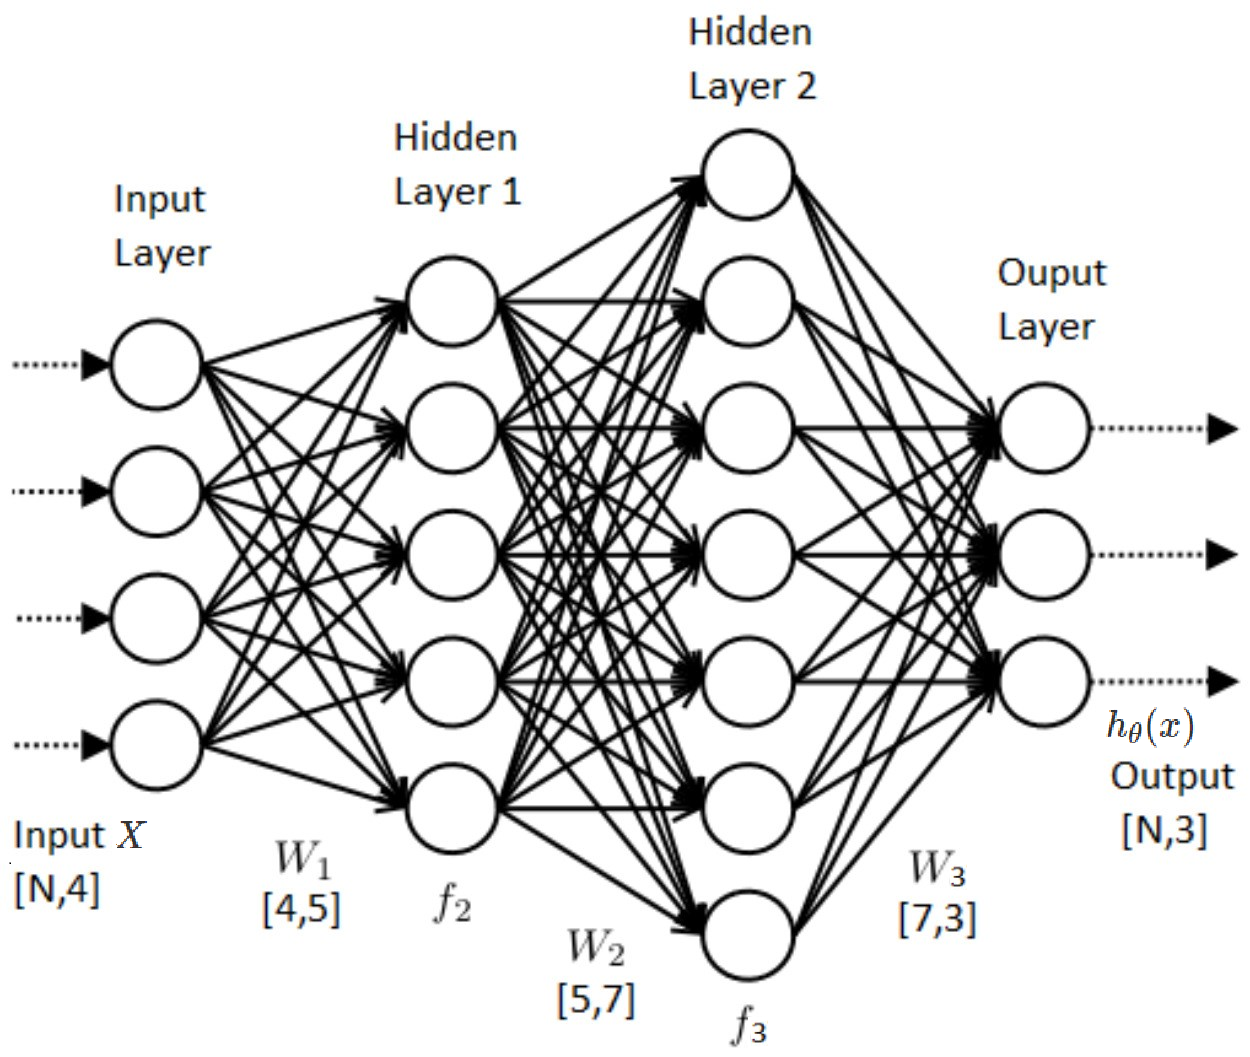

In [2]:
display.Image("images/2_layers_NN.png")

#### We import the data and initialize the weights

In [58]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()


X=np.reshape(x_train, (60000,784))
X=(X - np.mean(X)) / np.std(X)

x_test=np.reshape(x_test, (len(x_test),784))
x_test=(x_test - np.mean(x_test)) / np.std(x_test)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)




### Function for forward propagation

In [52]:
def forward_propagation(X, W1, B1, W2, B2, W3, B3):
    
    # W is a matrice with each row corresponding to the weights of 1 neural
    #W[i][j] is the weight going from neural i to neural j
    
    #Layer 1
    A1 = np.dot(W1, np.reshape(X, (784, 1))) + B1    
    X1= 1/(1+np.exp(-A1))
    
    
    #layer 2
    A2=np.dot(W2,X1) + B2
    X2= 1/(1+np.exp(-A2))
    
    #output layer
    A3=np.dot(W3,X2) + B3
    A3=A3.flatten()
    X3=np.exp(A3)/np.sum(np.exp(A3), axis=0, keepdims=True)

    X1=X1.flatten()
    X2=X2.flatten()
    
    return X1,X2,X3

### Function for back propagation

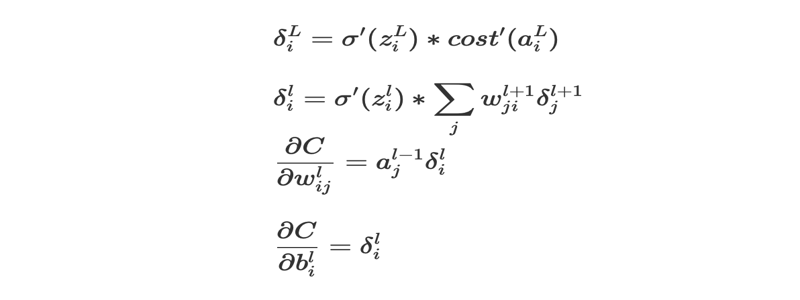

In [3]:
image = Image.open("images/Backpropagation.png")

# Define the desired width and height for the resized image
new_width = 800
new_height = 300

# Resize the image
resized_image = image.resize((new_width, new_height))

# Display the resized image
display.display(resized_image)

In [29]:
# first approach

def backpropagation(X,y,X1,W1,B1, X2,W2,B2,X3,W3,B3,learning_rate=0.1):
    
    #layer 3
    delta_3=[]
    for j in range(10):
        delta_3.append((X3[j]-y[j])*X3[j]*(1-X3[j]))
    
    delta_3=np.array(delta_3)
    
    weights_matrices_3=np.zeros((10,50))
    for i in range(10):
        for j in range(50):
            weights_matrices_3[i][j]=X2[j]*delta_3[i]
            
    
    #layer 2
    delta_2=[]
    for i in range(50):
        s=0
        for j in range(10):
            s+=W3[j][i]*delta_3[j]
        delta_2.append(s*(1-X2[i])*X2[i])
        
    delta_2=np.array(delta_2)

        
    weights_matrices_2=np.zeros((50,50))
    for i in range(50):
        for j in range(50):
            weights_matrices_2[i][j]=X1[j]*delta_2[i]
            
    #layer 1
    delta_1=[]
    for i in range(50):
        s=0
        for j in range(50):
            s+=W2[j][i]*delta_2[j]
        delta_1.append(s*(1-X1[i])*X1[i])
    
    delta_1=np.array(delta_1)

    weights_matrices_1=np.zeros((50,784))
    
    for i in range(50):
        for j in range(784):
            weights_matrices_1[i][j]=X[j]*delta_1[i]
            
    print(weights_matrices_2[1][4])     

            
    
    #update of the weigths
    W1_new= W1 - learning_rate * weights_matrices_1
    B1_new = B1 - np.reshape(delta_1, (len(delta_1), 1))
    
    W2_new=W2 - learning_rate*weights_matrices_2
    B2_new = B2 - np.reshape(delta_2, (len(delta_2), 1))

    
    W3_new = W3 - learning_rate*weights_matrices_3
    B3_new = B3 - np.reshape(delta_3, (len(delta_3), 1))



    return W1_new,W2_new,W3_new,B1_new,B2_new,B3_new

In [ ]:
def training_step(X, y, W1, B1, W2, B2, W3, B3):
    err = []
    W1_new, W2_new, W3_new = np.copy(W1), np.copy(W2), np.copy(W3)
    B1_new, B2_new, B3_new = np.copy(B1), np.copy(B2), np.copy(B3)
    
    for i, x in enumerate(X):
        # Forward propagation
        X1, X2, X3 = forward_propagation(x, W1_new, B1_new, W2_new, B2_new, W3_new, B3_new)
        
        # Error
        err.append(cross_entropy_loss(X3, y[i]))
        
        # Backpropagation
        W1_new, W2_new, W3_new, B1_new, B2_new, B3_new = backpropagation(x, y[i], X1, W1_new, B1_new, X2, W2_new, B2_new, X3, W3_new, B3_new)
        
    return err, np.copy(W1_new), np.copy(W2_new), np.copy(W3_new), np.copy(B1_new), np.copy(B2_new), np.copy(B3_new)




### Problem 

The first approach worked but it took too much time due to many for loops. To have better performance we are going to build the same model but with the numpy librairy. Thanks to this library our performance will be way better.

In [36]:

def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps, axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def cross_entropy_loss(prediction, y):
    epsilon = 1e-5
    num_samples = len(y)
    loss = -np.sum(y.T * np.log(prediction + epsilon)) / num_samples
    return loss

def backpropagation2(X, y, W1, B1, W2, B2, W3, B3, A1, X1, A2, X2, A3, X3, learning_rate):
    m = X.shape[1]

    # Calculate the derivatives
    dA3 = X3 - y.T
    dW3 = (1/m) * np.dot(dA3, X2.T)
    dB3 = (1/m) * np.sum(dA3, axis=1, keepdims=True)
    
    dX2 = np.dot(W3.T, dA3)
    dA2 = dX2 * sigmoid_derivative(A2)
    dW2 = (1/m) * np.dot(dA2, X1.T)
    dB2 = (1/m) * np.sum(dA2, axis=1, keepdims=True)
    
    dX1 = np.dot(W2.T, dA2)
    dA1 = dX1 * sigmoid_derivative(A1)
    dW1 = (1/m) * np.dot(dA1, X)
    dB1 = (1/m) * np.sum(dA1, axis=1, keepdims=True)
    
    # Update the weights and biases
    W1_new = W1 - learning_rate * dW1
    B1_new = B1 - learning_rate * dB1
    
    W2_new = W2 - learning_rate * dW2
    B2_new = B2 - learning_rate * dB2
    
    W3_new = W3 - learning_rate * dW3
    B3_new = B3 - learning_rate * dB3
    
    return W1_new, B1_new, W2_new, B2_new, W3_new, B3_new





    

In [71]:
def train(X, y, num_epochs, learning_rate):
    # Initialize weights and biases
    input_dim = X.shape[1]
    hidden_dim = 50  # Number of neurons in the hidden layer
    output_dim = 10

    W1 = np.random.randn(hidden_dim, input_dim) 
    B1 = np.zeros((hidden_dim, 1))
    W2 = np.random.randn(hidden_dim, hidden_dim) 
    B2 = np.zeros((hidden_dim, 1))
    W3 = np.random.randn(output_dim, hidden_dim) 

    B3 = np.zeros((output_dim, 1))

    # Training loop
    Loss=[]
    for epoch in range(num_epochs):
        # Forward propagation
        A1 = np.dot(W1, X.T) + B1
        X1 = sigmoid(A1)
        
        A2 = np.dot(W2, X1) + B2
        X2 = sigmoid(A2)
        A3 = np.dot(W3, X2) + B3
        X3 = softmax(A3)

        # Backpropagation
        W1, B1, W2, B2, W3, B3 = backpropagation2(X, y, W1, B1, W2, B2, W3, B3,A1,X1,A2,X2,A3,X3, learning_rate)

        # Print loss for tracking progress
        loss = cross_entropy_loss(X3, y)
        Loss.append(loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss}")

    return W1, B1, W2, B2, W3, B3, Loss


In [65]:
def evaluate(X, y, W1, B1, W2, B2, W3, B3):
    # Forward propagation
    A1 = np.dot(W1, X.T) + B1
    X1 = sigmoid(A1)
    A2 = np.dot(W2, X1) + B2
    X2 = sigmoid(A2)
    A3 = np.dot(W3, X2) + B3
    X3 = softmax(A3)

    # Predict labels
    predictions = np.argmax(X3, axis=0)
    true_labels = np.argmax(y, axis=1)
    
    print(true_labels)
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    
    return accuracy


In [73]:
W1, B1, W2, B2, W3, B3, Loss = train(X,y_train,500,0.1)


Epoch 1/500, Loss: 7.829511546070736
Epoch 2/500, Loss: 5.78956556738452
Epoch 3/500, Loss: 7.712017282701494
Epoch 4/500, Loss: 6.961974691700809
Epoch 5/500, Loss: 7.128268978617464
Epoch 6/500, Loss: 6.815053027327407
Epoch 7/500, Loss: 5.950301483421812
Epoch 8/500, Loss: 4.502601629014759
Epoch 9/500, Loss: 4.245975458779039
Epoch 10/500, Loss: 3.4253045485863964
Epoch 11/500, Loss: 3.1741844312543925
Epoch 12/500, Loss: 2.932414956143845
Epoch 13/500, Loss: 2.765564231940775
Epoch 14/500, Loss: 3.0419252994837973
Epoch 15/500, Loss: 2.39085003819601
Epoch 16/500, Loss: 2.6133382990444276
Epoch 17/500, Loss: 2.286634219222635
Epoch 18/500, Loss: 2.6452126228208486
Epoch 19/500, Loss: 2.4148559109999432
Epoch 20/500, Loss: 2.3264782702137494
Epoch 21/500, Loss: 2.1307072748167752
Epoch 22/500, Loss: 1.8422917940006265
Epoch 23/500, Loss: 1.7573938028968334
Epoch 24/500, Loss: 1.5123155176004055
Epoch 25/500, Loss: 1.6351086773867227
Epoch 26/500, Loss: 1.833500101200225
Epoch 27/50

Epoch 209/500, Loss: 0.35612978358886044
Epoch 210/500, Loss: 0.35521284546742177
Epoch 211/500, Loss: 0.3542592983397338
Epoch 212/500, Loss: 0.3533520761659599
Epoch 213/500, Loss: 0.3524123081671467
Epoch 214/500, Loss: 0.35151555564627956
Epoch 215/500, Loss: 0.35059040887780707
Epoch 216/500, Loss: 0.34970483146787623
Epoch 217/500, Loss: 0.3487948025938645
Epoch 218/500, Loss: 0.3479209883344823
Epoch 219/500, Loss: 0.3470262352520104
Epoch 220/500, Loss: 0.3461646482975167
Epoch 221/500, Loss: 0.3452850724191277
Epoch 222/500, Loss: 0.34443602114049604
Epoch 223/500, Loss: 0.3435713608673712
Epoch 224/500, Loss: 0.34273496367208245
Epoch 225/500, Loss: 0.34188487491733205
Epoch 226/500, Loss: 0.3410610616524761
Epoch 227/500, Loss: 0.3402251695978469
Epoch 228/500, Loss: 0.33941373795039465
Epoch 229/500, Loss: 0.3385916796767266
Epoch 230/500, Loss: 0.3377924217778835
Epoch 231/500, Loss: 0.33698393201497734
Epoch 232/500, Loss: 0.3361968157474163
Epoch 233/500, Loss: 0.3354018

Epoch 412/500, Loss: 0.2509136167745378
Epoch 413/500, Loss: 0.25059915079403583
Epoch 414/500, Loss: 0.2502856285048295
Epoch 415/500, Loss: 0.24997292320705375
Epoch 416/500, Loss: 0.2496611607988033
Epoch 417/500, Loss: 0.24935022177149604
Epoch 418/500, Loss: 0.2490402232291675
Epoch 419/500, Loss: 0.2487310531574161
Epoch 420/500, Loss: 0.2484228208785662
Epoch 421/500, Loss: 0.24811542193232392
Epoch 422/500, Loss: 0.24780895852750354
Epoch 423/500, Loss: 0.2475033336009472
Epoch 424/500, Loss: 0.2471986426843443
Epoch 425/500, Loss: 0.24689479585413088
Epoch 426/500, Loss: 0.2465918823427826
Epoch 427/500, Loss: 0.24628981917398102
Epoch 428/500, Loss: 0.24598868978901992
Epoch 429/500, Loss: 0.24568841818197135
Epoch 430/500, Loss: 0.24538908274018803
Epoch 431/500, Loss: 0.24509061465307336
Epoch 432/500, Loss: 0.2447930880578439
Epoch 433/500, Loss: 0.24449644142841934
Epoch 434/500, Loss: 0.2442007450203518
Epoch 435/500, Loss: 0.243905943964632
Epoch 436/500, Loss: 0.243612

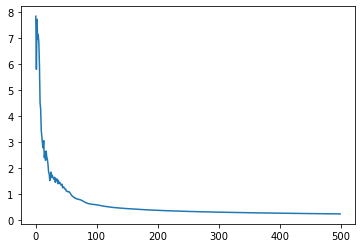

In [74]:
plt.figure(figsize=(12,12))
plt.plot(Loss,label="loss")
plt.xlabel('epochs')
plt.ylabel('loss')

In [70]:
print(evaluate(x_test,y_test,W1,B1,W2,B2,W3,B3))

[7 2 1 ... 4 5 6]
0.9082


### Accuracy 

After 500 epochs we have a score of 90% which is way better than our first model but we will see that it can still be improved with convolutional neural networks. 

We also have to notice that it might be some over learning, we could probably do less epochs.

# Part 3 : an approach by convolutional neural networks

In [4]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical


(x_train,y_train),(x_test,y_test)=mnist.load_data()


In [5]:
N=len(x_train)

x_train = np.reshape(x_train, (N,28,28,1))
x_test = np.reshape(x_test, (x_test.shape[0],28,28,1))

x_train=x_train/255
x_test=x_test/255


y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

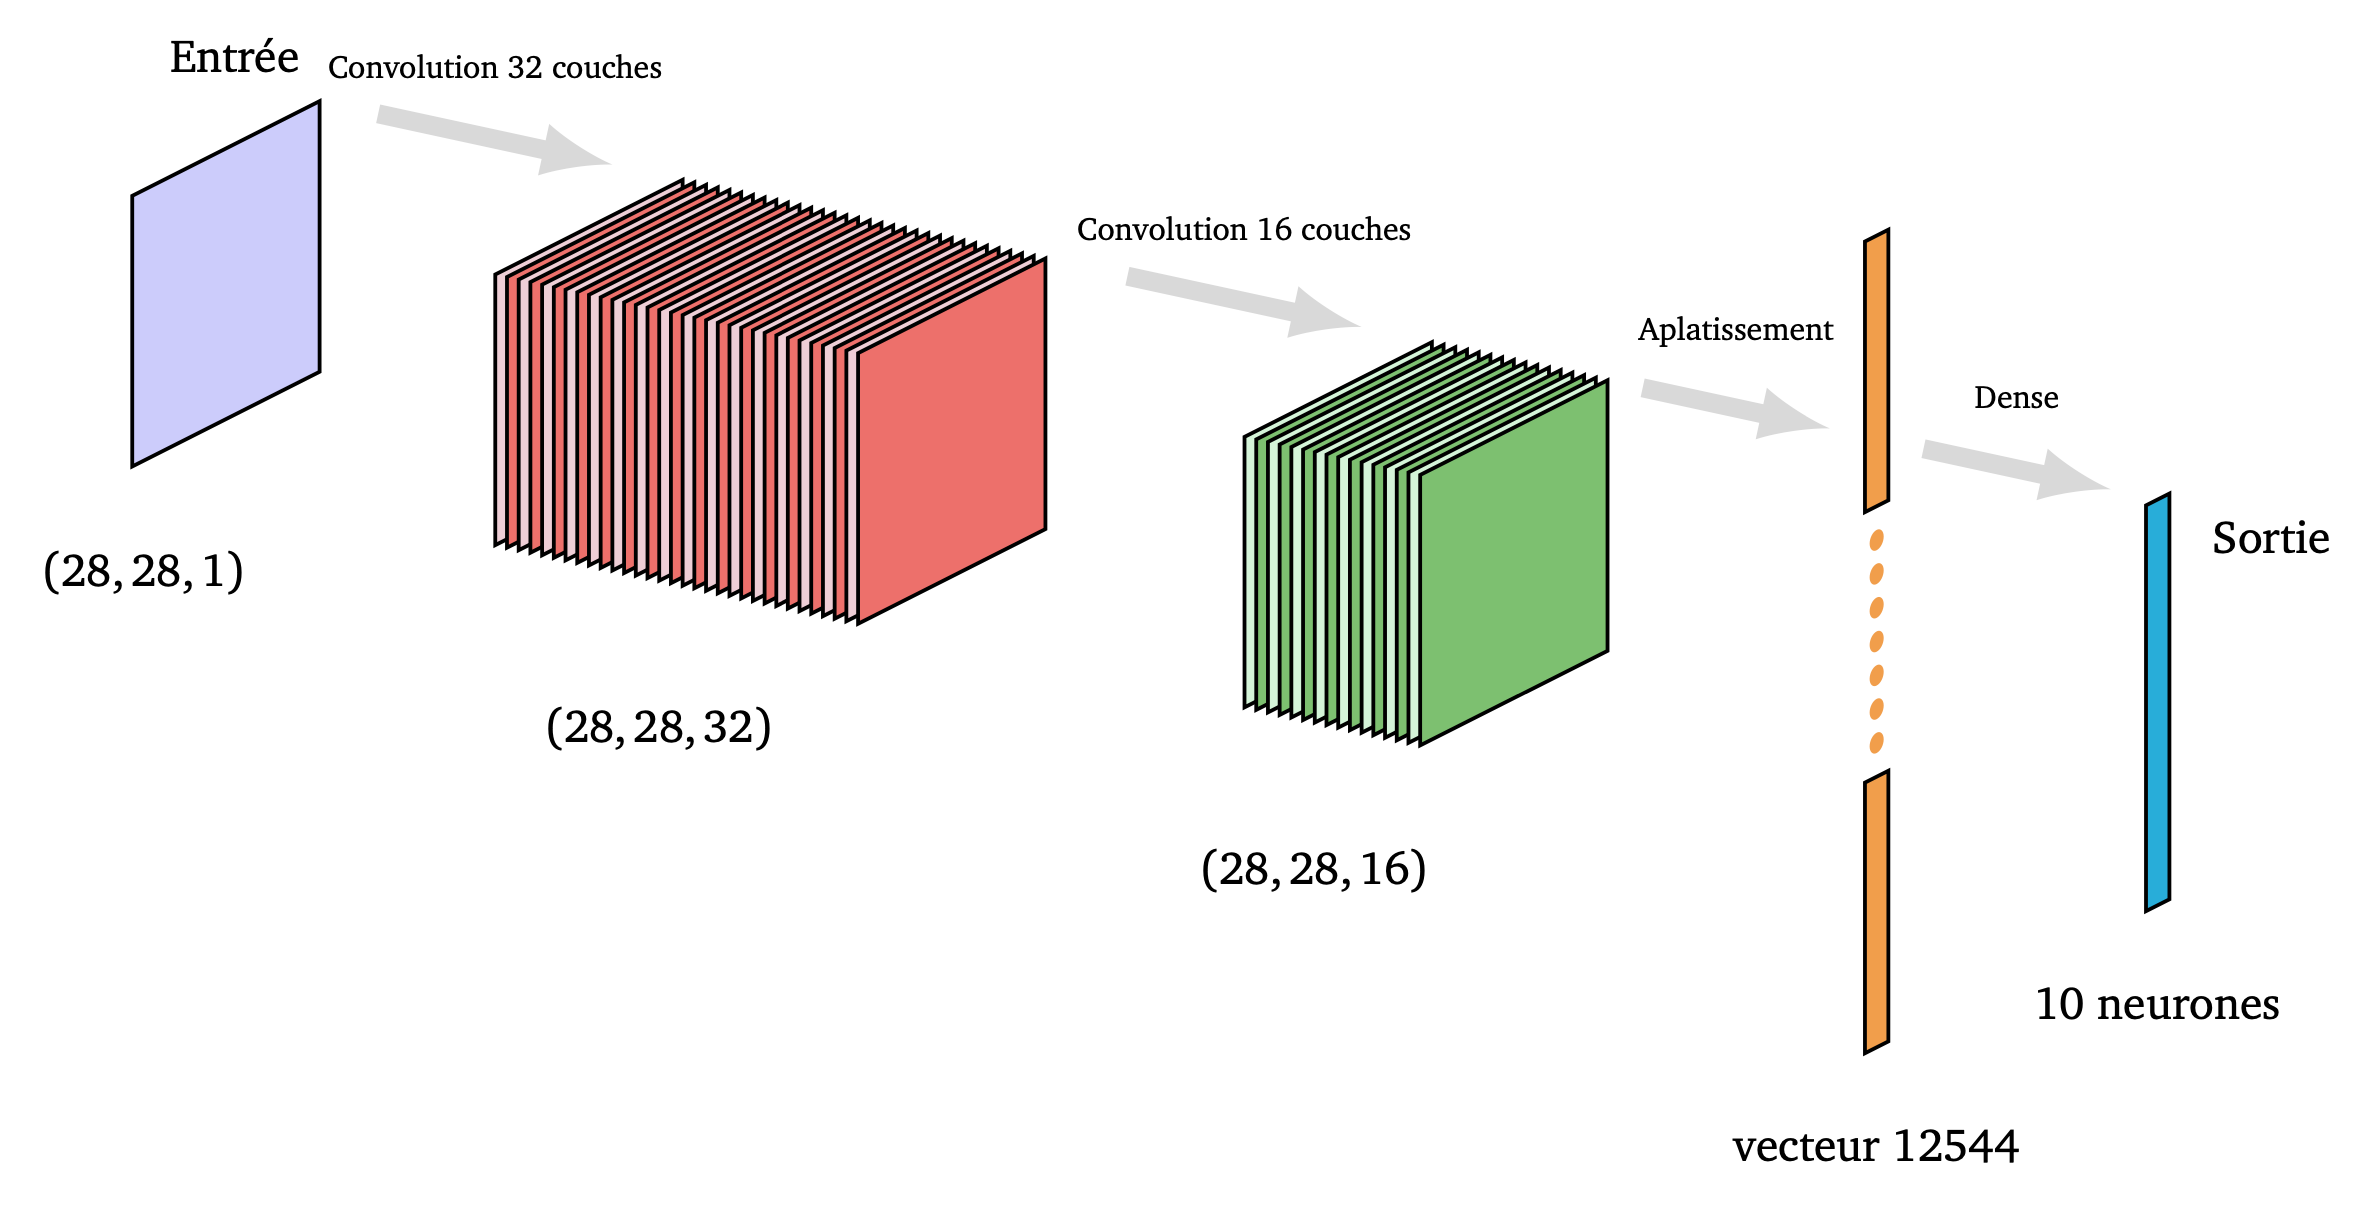

In [4]:
display.Image("images/CNN_image.png")

In [6]:
# build the model

model=Sequential()

#first convolution layer 
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))

#second convolution layer
model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))

#we flatten the model
model.add(Flatten())

#exit layer 
model.add(Dense(10, activation='softmax'))

#gradient descent
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                125450    
Total params: 130,394
Trainable params: 130,394
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# calculate the weights
model.fit(x_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1476 - accuracy: 0.9560
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0565 - accuracy: 0.9829
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0403 - accuracy: 0.9873
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0294 - accuracy: 0.9905
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0221 - accuracy: 0.9928


In [10]:
### results
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05413436517119408
Test accuracy: 0.9851000308990479


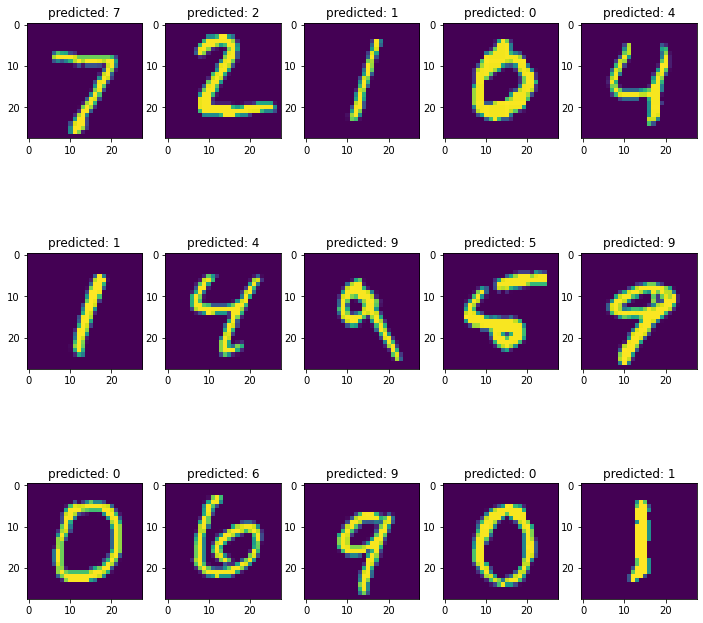

In [15]:
fig,ax= plt.subplots(ncols=5,nrows=3,figsize=(12,12))

s=0
for i in range(3):
    for j in range(5):
        ax[i,j].imshow(x_test[s])
        prediction = np.argmax(model.predict(np.expand_dims(x_test[s], axis=0)))
        ax[i, j].set_title("predicted: {}".format(prediction))
        s+=1

plt.show()

# Accuracy 

The accuracy is arround 98% which is the best model out of the three. Adding that it takes less time to compute than the other model.